# Capstone Project

### 2016 U.S. POTUS Primary Election

In [ ]:
import sys
import pandas as pd
#pd.set_option('display.max_rows', 1300)
import numpy as np
import matplotlib.pyplot as pl
import networkx as nx
import pygraphviz
import seaborn as sns
import sqlite3
import time
import pydot
import os

from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import tree
from sklearn.externals.six import StringIO  
from IPython.display import Image 
from sklearn.tree import export_graphviz
from StringIO import StringIO
from io import BytesIO

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
%sqlite_execute 

In [ ]:
%load_ext sql

In [ ]:
%load_ext sql
%sql sqlite:///database.sqlite
try:    
    db = sqlite3.connect('database.sqlite')
    c = db.cursor()
    print "Successfully connected to the database"
except IntegrityError:
    print"Did not successfully connect to database"

### SQL Commands:

In [ ]:
%sql SELECT * FROM primary_results

%sql ALTER TABLE primary_results ADD COLUMN county_state TEXT;
%sql UPDATE primary_results SET county_state = (county || "_" || state_abbreviation);
%sql UPDATE primary_results SET candidate = Replace(candidate,' ','_');

'''Create Republican Table:'''
%sql CREATE TABLE Republicans AS SELECT * FROM primary_results;
%sql DELETE FROM Republicans WHERE(party ='Democrat') 

'''Create Democrat Table:'''
%sql CREATE TABLE Democrats AS SELECT * FROM primary_results;
%sql DELETE FROM Democrats WHERE(party ='Republican') 

'''Update County Facts Table:'''
%sql UPDATE county_facts SET state_abbreviation = NULL WHERE state_abbreviation = '';
%sql DELETE FROM county_facts WHERE state_abbreviation IS NULL;
%sql ALTER TABLE county_facts ADD COLUMN county_state TEXT;
%sql UPDATE county_facts SET area_name = SUBSTR(area_name,1, LENGTH(area_name)-7);
%sql UPDATE county_facts SET county_state = (area_name || "_" || state_abbreviation);
%sql UPDATE county_facts SET county_state = REPLACE(county_state,'"','');

#Output County_Facts_Description as CSV file (.mode csv)
#%sql .output county_facts_dict.csv # command in terminal


'''SQL TABLES FOR TO GROUP WINNER OF EACH COUNTY:'''

#Identify the Republican winner in each county:
%sql SELECT state, state_abbreviation, county, fips, party, candidate, MAX(votes), fraction_votes, county_state FROM Republicans GROUP BY county ORDER BY state;
%sql CREATE TABLE Republican_Winner(state TEXT NOT NULL, state_abbreviation TEXT NOT NULL, county TEXT NOT NULL, fips INTEGER NOT NULL, party TEXT NOT NULL, candidate TEXT NOT NULL, votes INTEGER NOT NULL, fraction_votes INTEGER NOT NULL, county_state TEXT NOT NULL);
#.import republican_winners.csv Republican_Winner

#Identify the Democrat winner in each county:
%sql SELECT state, state_abbreviation, county, fips, party, candidate, MAX(votes), fraction_votes, county_state FROM Democrats GROUP BY county ORDER BY state;
%sql CREATE TABLE Democrat_Winner(state TEXT NOT NULL, state_abbreviation TEXT NOT NULL, county TEXT NOT NULL, fips INTEGER NOT NULL, party TEXT NOT NULL, candidate TEXT NOT NULL, votes INTEGER NOT NULL, fraction_votes INTEGER NOT NULL, county_state TEXT NOT NULL);
#.import democrat_winners.csv Democrat_Winner 

# Join Tables (county_facts and Republican/Democrat winner)
%sql SELECT * FROM Republican_Winner INNER JOIN county_facts WHERE Republican_Winner.county_state = county_facts.county_state;
%sql SELECT * FROM Democrat_Winner INNER JOIN county_facts WHERE Democrat_Winner.county_state = county_facts.county_state;

### Explore Data:

In [ ]:
# Generate Dataframe
df_primary_results = pd.read_sql_query('SELECT * FROM primary_results', db) #Primary Results 
df_county_facts = pd.read_sql_query('SELECT * FROM county_facts',db) #County Facts
df_republicans = pd.read_sql_query('SELECT * FROM Republicans',db) # Republican Table
df_democrats = pd.read_sql_query('SELECT * FROM Democrats', db) # Democrat Table

#County Facts Dictionary:
df_county_facts_dictionary = pd.read_sql_query('SELECT * FROM county_facts_dictionary ',db)

In [ ]:
# Primary results
df_primary_results.head()

In [ ]:
# County Facts data
df_county_facts.head()

In [ ]:
#shape of tables:
prim = df_primary_results.shape[0]
rep = df_republicans.shape[0]
dem = df_democrats.shape[0]
print "Primary Results..."
print "Total Number of Elements = {}; Republican: {}, Democrat :{}".format(prim,rep,dem)
print "Number of Features =", df_primary_results.shape[1]

#County Facts (shape):
print "\nCounty Facts...:"
print "Total Number of Elements =", df_county_facts.shape[0]
print "Number of Features =", df_county_facts.shape[1] -4


## Summary of Primary Results

In [ ]:
votes_sum = pd.read_sql_query('SELECT candidate, party, sum(votes) as sum_votes \
    FROM primary_results GROUP BY candidate, party ORDER BY sum_votes desc, party;',db)
#Candidate who suspended campaign: (drop from df)
to_del = votes_sum.loc[votes_sum['candidate'].isin(['Jeb_Bush', 'Ben_Carson','Rand_Paul',
    'Chris_Christie','Carly_Fiorina','Rick_Santorum','Mike_Huckabee',
    "Martin_O'Malley",'Marco_Rubio','_No_Preference','_Uncommitted'])].index.tolist()
votes = votes_sum.drop(to_del)

#Plots
sns.plt.figure(figsize=(10,6))
sns.barplot(y = 'candidate', x = 'sum_votes', data = votes, palette = "BuGn_r")
sns.plt.title('Total Votes per Candidate - Remaining', fontsize = 18)

sns.plt.figure(figsize=(10,6))
sns.barplot(y = 'candidate', x = 'sum_votes', data = votes_sum, palette = "BuGn_r")
sns.plt.title('Total Votes per Candidate - All', fontsize = 18)

In [ ]:
# republican winner by county:
rep_winner_county = pd.read_sql_query('SELECT candidate, count(candidate) \
    as count_county FROM Republican_Winner GROUP BY candidate ORDER BY count_county desc', db)
# democrat winner by county:
dem_winner_county = pd.read_sql_query('SELECT candidate, count(candidate) \
    as count_county FROM Democrat_Winner GROUP BY candidate ORDER BY count_county desc', db)

#plots
sns.plt.figure(figsize=(10,6))
sns.barplot(x = 'candidate', y = 'count_county', data = rep_winner_county, palette="PuBuGn_d")
sns.plt.title('Total Republican Primary Counties Won', fontsize = 18)

sns.plt.figure(figsize=(10,6))
sns.barplot(x = 'candidate', y = 'count_county', data = dem_winner_county, palette="PuBuGn_d")
sns.plt.title('Total Democrat Primary Counties Won', fontsize = 18)


# Republican Party:

In [ ]:
#Dataframe for Republican winners per county w/ county facts:
republican_data = pd.read_csv("republican_winners_county_facts.csv")
#drop repeated rows from merge
republican_data.drop(republican_data.columns[[1,9,10,11,63]], axis=1, inplace=True)

In [ ]:
g = sns.lmplot(x="SEX255214", y = "fraction_votes", data = republican_data, hue = "candidate", ci=False)
g.set_xlabels("Sex", size = 18)
g.set_ylabels("Fraction Votes", size = 18)
g.set(xlim=(20,60), ylim=(0,1))
sns.plt.title('Republican Winner', fontsize = 20)

## Split Training/Testing Set

In [ ]:
# First, remove all rows wrt candidates who suspended campaign:
to_del = republican_data.loc[republican_data['candidate'].isin(['Jeb_Bush', 'Ben_Carson','Rand_Paul','Chris_Christie','Carly_Fiorina','Rick_Santorum','Mike_Huckabee',"Marco_Rubio","_No_Preference","_Uncommitted"])].index.tolist()
republican_data = republican_data.drop(to_del)

# Arranging Data for Features & Targets
#republican_data = republican_data.replace(['Donald_Trump','Ted_Cruz','John_Kasich'],[1,2,3])

x_vars = list(republican_data.columns[8:]) 
x_vars= republican_data[x_vars] # Features
y_vars = republican_data['candidate'] # Target Labels
df_rep = pd.concat([x_vars,y_vars],axis=1) #combine Feautres/Target into one dataframe

feature_cols = list(df_rep.columns[:-1])  # all columns but last are features
target_col = df_rep.columns[-1]  # last column is the target/label

X_all = df_rep[feature_cols]  # feature values 
y_all = df_rep[target_col]  # corresponding targets/labels


In [ ]:
num_all = df_rep.shape[0]
num_train = int(num_all - (num_all*.25))
num_test = num_all - num_train

def Stratified_Shuffle_Split(X,y,num_test):
    sss = StratifiedShuffleSplit(y, 10, test_size=num_test, random_state = 42)
    for train_index, test_index in sss:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y_all, num_test)
print "Training Set: {0:.2f} Samples".format(X_train.shape[0])
print "Testing Set: {0:.2f} Samples".format(X_test.shape[0])


## Random Forest

In [ ]:
def train_classifier(clf, X_train, y_train):
    print "{}:".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    train_clf_time = end - start
    print "Training Time (secs): {:.3f}".format(train_clf_time)
    return train_clf_time

def predict_labels(clf, features, target):
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    prediction_time = end - start
    print "Prediction Time (secs): {:.3f}".format(prediction_time)
    return (f1_score(target.values, y_pred, pos_label= None, average = 'weighted'), prediction_time)

# Train and Predict
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    train_diff = train_classifier(clf, X_train, y_train)
    
    # Train and predict training set:
    f1_score_train, pred_time_train = predict_labels(clf, X_train, y_train)
    print "F1 score for TRAINING set:",(f1_score_train)
    # Predict on test data set:
    f1_score_test, pred_time_test = predict_labels(clf, X_test, y_test)
    print "F1 score for TEST set:",(f1_score_test)
    
    return (f1_score_train, f1_score_test, train_diff, pred_time_test)


In [ ]:
clf_RF = RandomForestClassifier(n_estimators=10)

def run_all_models(classifiers):
    names = feature_cols
    #df_c = pd.DataFrame()
    for clf in classifiers:
        df = pd.DataFrame(columns = [
                    'Training_Size',
                    'Testing_Size',
                    'Training_Time',
                    'Prediction_Time',
                    'F1_Score_Training',
                    'F1_Score_Testing'])

        X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y_all, num_test)
        
        num_times_to_run = 2
        sizes = [X_test.shape[0]]
        for size in sizes: 
            for x in range(0, num_times_to_run): 
                f1_score_train, f1_score_test, train_time, pred_time_test = train_predict(clf, X_train[:size], y_train[:size], X_test, y_test)
        
                '''Confusion Matrix: Testing Set'''
                y_pred = clf.fit(X_train, y_train).predict(X_test)
                cm = confusion_matrix(y_test, y_pred)
                print "\nConfusion Matrix:"
                print cm

                #Feature Importance:
                feature_imp = sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), names), 
                reverse=True)      
                df = df.append({
                        'Training_Size': len(X_train[:size]),
                        'Testing_Size': X_test.shape[0],
                        'Training_Time': train_time,
                        'Prediction_Time': pred_time_test,
                        'F1_Score_Training': f1_score_train,
                        'F1_Score_Testing': f1_score_test}, 
                        ignore_index= True)
            
            #Feature Importance
            columns = ['Importance','Feature']
            df_imp = pd.DataFrame(feature_imp, columns = columns)
            
            #mean statistics:
            df = df[(df.Training_Size == size)]
            df_mean = df.mean()
            
            print "**********************************************************"
            print "Mean Statistics:"
            print df_mean
            print "**********************************************************"
            print "Feature Importance:"
            print df_imp
            print "**********************************************************"
    
    pl.figure
    feature_plot(df_imp)
        
def feature_plot(df_imp):
    ax = df_imp.plot(x='Feature', y='Importance',kind='bar'
        ,figsize=(15,10), color= 'b',
        alpha= 0.8, legend=True)
    ax.set_title('Feature Importance', fontsize = 24)
    ax.set_ylabel('Importance', fontsize= 16)
    ax.set_xlabel('Feature',fontsize= 16)
    pl.show()

In [ ]:
run_all_models([clf_RF])

## Fine Tune Model:

In [142]:
def iterate_fit_predict(number_runs):
    f1_scores = []
    
    for num in range(0, number_runs):
        X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y_all, num_test)
        parameters = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
        clf_GS = GridSearchCV(clf_RF, parameters, scoring = 'f1')
        
        '''Confusion Matrix: Testing Set'''
        y_pred = clf_GS.fit(X_train, y_train).predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        np.set_printoptions(precision=2)
        pl.figure()
        plot_confusion_matrix(cm, title='Confusion Matrix')
        
        #Fit classifier to training data:
        clf_GS.fit(X_train,y_train)
        f1_scores.append(clf_GS.score(X_test,y_test))
        #clf = clf.best_estimator_s
    
    df_f1 = pd.Series(f1_scores)
    print clf_GS
    print "\nF1 Scores:"
    print round(df_f1,4)
    
    print "\n Average F1 Test Scores:"
    print round(df_f1.mean(),4)
    
    print "\n Confusion Matrix:"
    print cm
    
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=pl.cm.Blues):
    names = ['Trump','Cruz','Kasich']
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.title(title, fontsize =20)
    pl.colorbar()
    tick_marks = np.arange(len(names))
    pl.xticks(tick_marks,names, rotation=45)
    pl.yticks(tick_marks,names)
    pl.tight_layout()
    pl.ylabel('True label', fontsize =16)
    pl.xlabel('Predicted label', fontsize =16)
 

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

F1 Scores:
0.7986

 Average F1 Test Scores:
0.7986

 Confusion Matrix:
[[161   1  15]
 [  8   1   1]
 [ 36   1  59]]


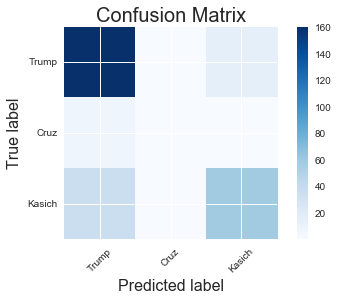

In [143]:
iterate_fit_predict(1)

## Decision Tree - Classification

In [202]:
# Replace candidate value with name:
#df_rep.ix[df_rep.candidate == 1, 'candidate'] = 'Donald_Trump'
#df_rep.ix[df_rep.candidate == 2, 'candidate'] = 'Ted_Cruz'
#df_rep.ix[df_rep.candidate == 3, 'candidate'] = 'John_Kasich'
#Decision Tree Data Frame
df_rep_dt = df_rep
#df_rep_dt.drop('candidate',axis=1,inplace = True)


list_of_dic = df_rep_dt.T.to_dict().values()
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
vec.fit_transform(list_of_dic).toarray()
feature_names = vec.get_feature_names()



In [207]:
from sklearn import tree
from sklearn.datasets import load_iris
from IPython.display import Image 
import os


target_names = ['Donald_Trump','Ted_Cruz','John_Kasich']

clf = tree.DecisionTreeClassifier(min_samples_split=20,min_samples_leaf=20)
clf = clf.fit(X_train, y_train)

def create_tree(clf):
    with open("tree.dot", 'w') as f:
        f = tree.export_graphviz(clf, out_file=f)
        
    os.unlink('tree.dot')
    
    dot_data = StringIO() 
    tree.export_graphviz(clf, out_file=dot_data,feature_names=vec.get_feature_names(),  
                             class_names=target_names) 
    graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
    graph.write_pdf("tree.pdf") 


    dot_data = StringIO()  
    tree.export_graphviz(clf, out_file=dot_data,  
                             feature_names=vec.get_feature_names(),  
                             class_names=target_names,  
                             filled=True, rounded=True,  
                             special_characters=True)  
    graph = pydot.graph_from_dot_data(dot_data.getvalue())  
    Image(graph.create_png()) 


In [208]:
create_tree(clf)

Apr 14 01:47:10 Trace-Smiths-MacBook-Pro.local dot[1039] <Error>: The function ‘CGFontGetGlyphPath’ is obsolete and will be removed in an upcoming update. Unfortunately, this application, or a library it uses, is using this obsolete function, and is thereby contributing to an overall degradation of system performance.
Apr 14 01:47:10 Trace-Smiths-MacBook-Pro.local dot[1039] <Error>: The function ‘CGFontGetGlyphPaths’ is obsolete and will be removed in an upcoming update. Unfortunately, this application, or a library it uses, is using this obsolete function, and is thereby contributing to an overall degradation of system performance.

